# Libs

In [2]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Masking
import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from WickelfeaturesProject.keras_metrics import KerasMetrics
from keras.optimizers import adam
import keras.backend as K
from sklearn.metrics import f1_score
from scipy.spatial import distance
import pickle
opt = adam()

Using TensorFlow backend.


# Data

corpus = pd.read_csv("WickelfeaturesProject/Corpus new coding/corpus_complete.csv", names=['verb0', 'inf_verb', 'conj_verb0', 'conj_verb'])

corpus.drop(['verb0','conj_verb0'], axis=1,inplace=True)

corpus['conj_verb'] = corpus.conj_verb.apply(lambda x: x.strip('#'))

corpus['inf_verb'] = corpus.inf_verb.apply(lambda x: x.strip('#'))

corpus.to_csv('WickelfeaturesProject/Corpus new coding/actual_corpus_used', index=False)

In [10]:
corpus = pd.read_csv('WickelfeaturesProject/Corpus_new_coding/actual_corpus_used', index_col='Unnamed: 0')

In [11]:
corpus.head()

,inf_verb,conj_verb
0,Ansia,Anseiu
1,odia,odeiu
2,pleitea,pleiteiu
3,ins3ndia,ins3ndeiu
4,sortea,sorteiu


In [13]:
corpus['conj_verb'] = corpus.conj_verb.apply(lambda x: '#'+x+ '$')

In [14]:
corpus.head()

,inf_verb,conj_verb
0,Ansia,#Anseiu$
1,odia,#odeiu$
2,pleitea,#pleiteiu$
3,ins3ndia,#ins3ndeiu$
4,sortea,#sorteiu$


In [16]:
corpus.to_csv('WickelfeaturesProject/Corpus_new_coding/actual_corpus_used', index=False)

# Features

In [28]:
features = ['oclusiva', 'nasal', 'tepe', 'fricativa', 'l-aprox', 'bilabial', 'labiodental',
           'alveolar', 'p-alveolar', 'palatal', 'velar', 'glotal', 'vozeada', 'fechada',
           'm-fechada', 'm-aberta', 'aberta', 'anterior', 'posterior', 'beg', 'end']

In [29]:
#http://www.ipachart.com/
phones = {
"p" : ['bilabial', 'oclusiva'],
"b" : ['bilabial', 'oclusiva', 'vozeada'],
"f" : ['labiodental', 'fricativa'],
"v" : ['labiodental', 'fricativa', 'vozeada'],
"t" : ['alveolar', 'oclusiva'],
"d" : ['alveolar', 'oclusiva', 'vozeada'],
"m" : ['bilabial', 'nasal'],
"n" : ['alveolar', 'nasal'],
"k" : ['velar', 'oclusiva'],
"g" : ['velar', 'oclusiva', 'vozeada'],
"N" : ['nasal', 'palatal'],
"r" : ['alveolar', 'tepe'],
"s" : ['alveolar', 'fricativa'],
"z" : ['alveolar', 'fricativa', 'vozeada'],
"j" : ['p-alveolar', 'fricativa', 'vozeada'],
"l" : ['l-aprox', 'p-alveolar'],
"L" : ['l-aprox', 'palatal'],
"h" : ['glotal', 'fricativa'],
"x" : ['fricativa', 'p-alveolar'],
"i" : ['anterior', 'fechada'],
"e" : ['m-fechada', 'anterior'],
"E" : ['m-aberta', 'anterior'],
"a" : ['anterior', 'aberta'],
"u" : ['posterior', 'fechada'],
"o" : ['m-fechada', 'posterior'],
"O" : ['m-aberta', 'posterior'],
"A" : ['anterior', 'aberta', 'nasal'],
"3" : ['m-fechada', 'anterior', 'nasal'],
"PAD": [''],
"#" : ['beg'],
"$" : ["end"]}

In [30]:
with open('WickelfeaturesProject/Files/phones.pickle', 'wb') as file:
    pickle.dump(phones, file, protocol=pickle.HIGHEST_PROTOCOL)

# Functions

In [31]:
def code(phone): 
    array = []
    for item in features:
        if item in phones[phone]:
            array.append(1)
        else:
            array.append(0)
    return np.array(array)

In [32]:
code('h')

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
code('#')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [34]:
def code_verb(verb):
    coded = list()
    for item in verb:
        coded.append(code(item))
    return coded

In [35]:
#code_verb('falu')

In [36]:
# def verify(verb):
#     for phone in verb:
#         if phone not in phones.keys():
#             print(phone, verb)
#         else:
#             None

In [37]:
phones.keys()

dict_keys(['p', 'b', 'f', 'v', 't', 'd', 'm', 'n', 'k', 'g', 'N', 'r', 's', 'z', 'j', 'l', 'L', 'h', 'x', 'i', 'e', 'E', 'a', 'u', 'o', 'O', 'A', '3', 'PAD', '#', '$'])

In [17]:
# corpus.inf_verb.apply(verify)

0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
       ... 
393    None
394    None
395    None
396    None
397    None
398    None
399    None
400    None
401    None
402    None
403    None
404    None
405    None
406    None
407    None
408    None
409    None
410    None
411    None
412    None
413    None
414    None
415    None
416    None
417    None
418    None
419    None
420    None
421    None
422    None
Name: inf_verb, Length: 423, dtype: object

# Maximum Length of input and output

In [38]:
corpus.inf_verb.str.len().max()

11

In [40]:
max_decoder_seq_length = corpus.conj_verb.str.len().max()

In [41]:
max_decoder_seq_length

13

# Padding

In [43]:
coded_in = corpus.inf_verb.apply(code_verb)

In [113]:
input_texts = corpus.inf_verb[-30:]

In [44]:
coded_out = corpus.conj_verb.apply(code_verb)

In [45]:
# # define sequences
# sequences = [
#     [1, 2, 3, 4],
#        [1, 2, 3],
#              [1]
#     ]
# # pad sequence

In [50]:
coded_in[0]

[array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])]

In [51]:
padded_in = pad_sequences(coded_in, value=np.zeros(21))
padded_out = pad_sequences(coded_out, value=np.zeros(21),padding="post")

In [52]:
padded_out = pad_sequences(coded_out, value=np.zeros(21),padding="post")
padded_out.shape

(423, 13, 21)

about pre padding: https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results

# Test Split

In [53]:
x_test = padded_in[-30:]
y_test = padded_out[-30:]

padded_in = padded_in[:-30]
padded_out = padded_out[:-30]

# The Network

In [65]:
latent_dim = 256
num_encoder_tokens = 21

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens)) #19
#encoder_inputs = Masking()(encoder_inputs) # Assuming PAD is zeros
encoder = LSTM(latent_dim, return_state=True)
# Now the LSTM will ignore the PADs when encoding
# by skipping those timesteps that are masked
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
num_decoder_tokens = 21
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [66]:
num_encoder_tokens

21

In [67]:
padded_out[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)

In [59]:
coded_out_target = coded_out.apply(lambda x: np.vstack((x[1:],np.zeros(21))))

In [60]:
padded_out.shape

(393, 13, 21)

In [61]:
padded_out_target = pad_sequences(coded_out_target, value=np.zeros(21),padding="post")

In [62]:
padded_out_target.shape

(423, 13, 21)

In [63]:
#because of test split
padded_out_target = padded_out_target[:-30]

In [142]:
def mean_pred(y_true, y_pred):
    print(K.shape(y_true))
    return K.mean(y_pred[y_true == 1])

In [143]:
def mean_pred(y_true, y_pred):
    
    return K.mean(y_pred[y_true == 1])

In [69]:
%%time
# Run training
keras_metrics = KerasMetrics()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[ keras_metrics.fbeta_score,
               keras_metrics.recall,
               keras_metrics.precision]) #, mean_pred],)
model.save_weights('WickelfeaturesProject/new_model_1.h5')
history = model.fit([padded_in, padded_out],
                    padded_out_target,
                    batch_size=128,
                    epochs=140,
                    validation_split=0.2,verbose=True)

Train on 314 samples, validate on 79 samples
Epoch 1/140
314/314 [==============================] - 2s 5ms/step - loss: 0.1603 - fbeta_score: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.1657 - val_fbeta_score: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/140
314/314 [==============================] - 1s 3ms/step - loss: 0.1552 - fbeta_score: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.1633 - val_fbeta_score: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/140
314/314 [==============================] - 1s 3ms/step - loss: 0.1506 - fbeta_score: 0.0000e+00 - rec

In [189]:
history2.history.keys()

dict_keys(['val_loss', 'val_fbeta_score', 'val_recall', 'val_precision', 'loss', 'fbeta_score', 'recall', 'precision'])

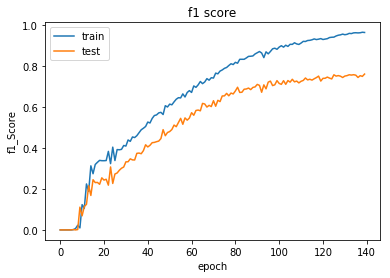

In [71]:
# summarize history for accuracy
plt.plot(history.history['fbeta_score'])
plt.plot(pd.Series(history.history['val_fbeta_score']))
plt.title('f1 score')
plt.ylabel('f1_Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [72]:
history.history['val_fbeta_score'][-1]

0.7599242925643921

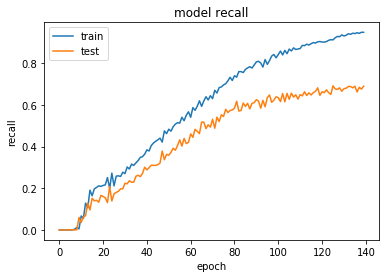

In [74]:
# summarize history for accuracy
score = 'recall'
plt.plot(history.history[score])
plt.plot(pd.Series(history.history['val_{}'.format(score)]))
plt.title('model {}'.format(score))
plt.ylabel(score)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [75]:
history.history['val_recall'][-1]

0.690128743648529

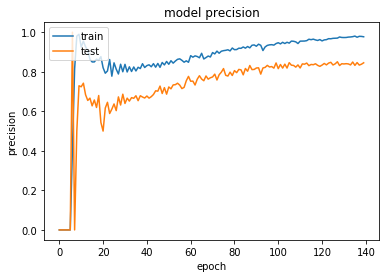

In [76]:
score = 'precision'
plt.plot(history.history[score])
plt.plot(pd.Series(history.history['val_{}'.format(score)]))
plt.title('model {}'.format(score))
plt.ylabel(score)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [78]:
history.history['val_precision'][-1]

0.8454258441925049

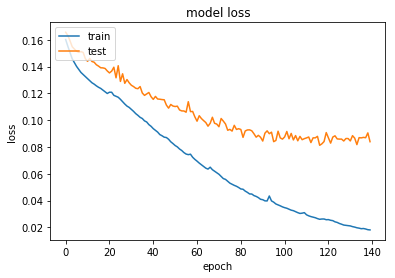

In [79]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Predict

## Euclidean Distance

from scipy.spatial import distance
a = np.array([0,0,1])
b = np.array([0, 0, 1])
dst = distance.euclidean(a, b)
dst

In [ ]:
# phone_arrays = {}
# for phone in phones:
#     phone_arrays[phone] = code(phone)
# phone_arrays

In [ ]:
# import pickle
# with open('WickelfeaturesProject/Files/phone_arrays.pickle', 'wb') as file:
#     pickle.dump(phone_arrays, file, protocol=pickle.HIGHEST_PROTOCOL)

In [80]:
def find_closest_array(predicted):
    """
    Find closest array.
    
    Parameters:
    ----------   
    predicted : type array
    
    Returns:
    -------
    candidate : type string
    """
    min_dst = 10000
    candidates = []
    import pickle 
    with open('WickelfeaturesProject/Files/phone_arrays.pickle', 'rb') as file:
        phone_arrays = pickle.load(file)
    
    for phone in phone_arrays:
        dst = distance.euclidean(predicted, phone_arrays[phone])
        # finds the minimum distance first
        if dst < min_dst:
            min_dst = dst
            
    for phone in phone_arrays:
            dst = distance.euclidean(predicted, phone_arrays[phone])
            if dst == min_dst:
                # appends all possible candidates to a list
                candidates.append(phone)
    if len(candidates) > 1:
        return '(' + ''.join(candidates) + ')'
    else:
        return ''.join(candidates)

In [81]:
# test if it returns 3
find_closest_array([0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

'3'

In [82]:
# test if it returns a list
find_closest_array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

'(ptk)'

 ---

## Inference mode

In [102]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [84]:
lookup = {}
for phone in phones:
    lookup[phone] = code(phone)    

In [85]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'wb') as file:
    pickle.dump(lookup, file, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
def reverse_phone(array):
    for item in lookup:
        if np.all(array == lookup[item]):
            return item

In [88]:
coded_in[0][0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [89]:
reverse_phone(coded_in[0][0])

'A'

In [91]:
reverse_phone([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

'PAD'

In [98]:
lookup

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [109]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'rb') as file:
    lookup = pickle.load(file)
    
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 13, 21)) # max decoder len = 13, 21 features
    max_decoder_seq_length = 13
    
    #Populate the first character of target sequence with the start character.
    target_seq[0, 0, lookup['#']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_verb = ''
    while not stop_condition:
        output_phones, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a phone
        sampled_phone_vector = np.argmax(output_phones[0, -1, :])        
        sampled_phone = find_closest_array(sampled_phone_vector)
        decoded_verb += sampled_phone

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_phone == '$' or 
           len(decoded_verb) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_phone_vector] = 1.

        # Update states
        states_value = [h, c]

    return decoded_verb

In [149]:
for x in x_test:
    decoded_verb = decode_sequence(encode_sequence(np.array(code_verb())))
    print(decoded_verb)
    break

ValueError: Error when checking : expected input_5 to have 3 dimensions, but got array with shape (5, 21)

In [115]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = x_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: sabe
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: ekivale
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: prove
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: traze
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: pode
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: desda
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: idea
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: estrea
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: da
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: sobresta
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: esta
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: kabe
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: ouvi
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: entreouvi
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: heouvi
Decoded sentence: (bvdgzjA3)(bvdgzjA3)
-
Input sentence: pari
Decoded sentence: (bvdgzjA3)(b